# Nicholas Tam Final Visualization

## Research Question/Interests
Research question: Given the tree dataset, how would we want to arrange the types of trees to be planted in certain locations, such that they could survive and significantly improve the ecosystem?

Given the research question, it would be ideal to analyze relevant properties, such as the relative sizes of each location and the proportions of planted trees for each species.

The following questions will be used as guidelines to supplement the question:
- What are the numbers and proportions of planted trees, by species and genus?
- Which locations within each neighbourhood can host wide varieties of species?
- How do trees that have been planted directly compare in terms of diameter and height to those that have grown naturally?

## Subquestion of interest: Which locations within each neighbourhood can host wide varieties of species?

In [1]:
import altair as alt
import pandas as pd
from toolz.curried import pipe
import os
from pygbif import species

import sys
sys.path.append("../../code")
sys.path.append("../../images")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer
from IPython.display import Image
import geopandas as gpd
import json

In [2]:
# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

# Set up file path to save images
viz_folder = '../../images/ntam_viz/'

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('json_dir')

## Processed Data
- Upon loading `public_trees_cleaned_filled_neighbhour.csv`, need to set the attribute types for `HEIGHT_RANGE`, `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK`.
- `public_trees_planted` is created to filter for species with existing planted trees.

In [3]:
# public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned.csv")
public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned_filled_neighbhour.csv")
priority_order = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90']
public_trees_cleaned['HEIGHT_RANGE'] = pd.Categorical(public_trees_cleaned['HEIGHT_RANGE'], categories=priority_order, ordered=True)
public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']] = public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']].astype(str)

public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,3.0,2014-12-03,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,12.0,2010-08-11,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,3.0,NaN,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-10-12,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-10-12,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False


In [4]:
planted_species = public_trees_cleaned.loc[public_trees_cleaned['DATE_PLANTED'].notnull(), 'SPECIES_NAME'].unique()
public_trees_planted = public_trees_cleaned[public_trees_cleaned['SPECIES_NAME'].isin(planted_species)]

## Visualization 2: Which planted species exist in many different locations within each neighbourhood?

### Marks
- Choropleth:  
  - Used to display proportions of streets within Vancouver neighborhoods with sufficient species variation, 15 in this case.  
  - The geospatial layout provides geographic context, helping users quickly identify areas with higher or lower homogeneity.  
  - Color intensity (`viridis` scheme) encodes proportions of streets within the neighbourhood with over 15 different species, emphasizing areas with the most extreme variations of species diversity. 
- Bar plot:
  - Used to provide more detailed information within each neighbourhood on the counts of species for each street.
  - Bar lengths represent number of species within specific streets, enabling users more detailed information on species variation that would be difficult to display on the choropleth.

### Channels
- Choropleth: 
  - Position: Geographic boundaries represent neighborhoods, offering spatial context for biodiversity distribution.  
  - Color: Encodes proportions of streets within the neighbourhood with over 15 different species (`viridis` scheme), emphasizing areas with the most extreme variations of species diversity.
  - Opacity: Upon selection of an area, the opacity of all other areas are set to be low, drawing attention to the area under analysis.
  - Tooltip: Provides additional details like neighborhood name, number of streets, and proportion of streets with high variety, enhancing interpretability.   
- Bar plot:
  - Position:  
    - Y-axis represents neighbourhoods.
    - X-axis represents the counts of species within each street.
  - Color represents the street's corresponding neighbourhood, primarily to group the locations appropriately. The customised color scheme set was intended such that colorblind individuals would be able to perceptual group and differentiate the streets between categories close to each other.
  - Tooltip: Displays the corresponding neighbourhood, street and number of distinct species, improving clarity.

### Interaction and UI Widgets 
- Mouse-Based Neighborhood Selection:  
  - Users can click on a specific neighborhood in the map to filter the bar chart, displaying detailed data for that neighborhood. 

- Linked Filtering:  
  - Ensures the choropleth and bar chart remain synchronized. Clicking on a neighborhood updates both visualizations, creating a cohesive exploration experience.

- Conditional Highlighting:  
  - Upon selection of an area, the opacity of all other areas are set to be low, drawing attention to the area under analysis, improving focus and reducing cognitive load.

- Tooltip Enhancements:  
  - Tooltips provide precise numerical values for counts of streets with sufficient species variation and specific number of distinct species corresponding to each location, enhancing interpretability without cluttering the visualization. 

### Tasks Supported by the Visualization
- Retrieve Value: Tooltips allow users to extract specific details, such as counts of streets with sufficient species variation and specific number of distinct species corresponding to each location. 
- Filter: Users can filter data by selection in the choropleth, enabling focused exploration.  
- Compute Derived Value: To obtain the proportion of streets with sufficient species variation, two aggregations were required. The first aggregation involved counting the number of unique species within each street, while the second involved counting the number of streets within each neighbourhood. The proportion was obtained by dividing the number of streets that had sufficient numbers of distinct species over the total number of streets within each neighbourhood.
- Sort: Neighborhoods are implicitly ranked by proportion of streets with sufficient species variation (via color intensity on the map), and species variations are sorted by neighbourhood in the bar chart.

### Why These Choices Were Effective
- Data Processing:  
   - Aggregating unique species counts per street and extent of species variation within each neighbourhood ensures the visualization is concise and focused on significant contributors to biodiversity.  
   - Filtering the dataset avoids overwhelming users with less relevant data while still providing meaningful insights into biodiversity patterns.  

- Comprehensive Analysis:  
   - The map provides an overview of spatial patterns, highlighting areas with high or low biodiversity.
   - The bar chart complements the map by offering detailed insights into the composition of biodiversity, breaking down data by locations.  
   - Together, they provide a holistic view of Vancouver’s urban tree ecosystem, balancing broad overviews with granular analyses.

- Dynamic Exploration:  
   - Mouse-based neighborhood selection and linked filtering enable seamless exploration, allowing users to transition from spatial patterns to location-level breakdowns.  
   - Conditional highlighting improves focus, reducing cognitive load and enhancing interpretability.

- Enhanced Interpretability:  
   - Tooltips and conditional highlighting make the visualization accessible to a wide audience, supporting informed decision-making about neighborhoods with greater flexibility in terms of species sustainability.  

### Further Developments 
- The selected baseline of species variation may not be sufficient, and thus further UI widgets to provide options for such may be considered.
- The sheer quantity of neighbourhoods means that the neighbourhood locations in the bar plot run the risk of being indiscriminable.

In [5]:
gdf = gpd.read_file("../../data/processed/local_area_boundary.geojson")
gdf['NEIGHBOURHOOD_NAME'] = gdf['name'].str.upper() # To make name compatible with other dataset
# gdf = gdf.rename(columns={"name": "NEIGHBOURHOOD_NAME"})
# gdf['NEIGHBOURHOOD_NAME'] = gdf['NEIGHBOURHOOD_NAME'].str.upper()
geo_data = gpd.GeoDataFrame(gdf)
# geo_data = gdf
geo_data

,name,center_lon,center_lat,geometry,NEIGHBOURHOOD_NAME
0,Dunbar-Southlands,-123.189547,49.237962,"POLYGON ((-123.17 49.248, -123.17 49.235, -123...",DUNBAR-SOUTHLANDS
1,Fairview,-123.131049,49.264540,"POLYGON ((-123.15 49.257, -123.15 49.272, -123...",FAIRVIEW
2,Mount Pleasant,-123.098513,49.263065,"POLYGON ((-123.1 49.269, -123.1 49.267, -123.1...",MOUNT PLEASANT
3,Renfrew-Collingwood,-123.040166,49.247343,"POLYGON ((-123.02 49.235, -123.02 49.232, -123...",RENFREW-COLLINGWOOD
4,West End,-123.135438,49.285011,"POLYGON ((-123.14 49.275, -123.14 49.278, -123...",WEST END
5,Arbutus Ridge,-123.161669,49.246805,"POLYGON ((-123.15 49.257, -123.16 49.257, -123...",ARBUTUS RIDGE
6,Grandview-Woodland,-123.066728,49.276440,"POLYGON ((-123.08 49.29, -123.07 49.29, -123.0...",GRANDVIEW-WOODLAND
7,Kensington-Cedar Cottage,-123.072885,49.246686,"POLYGON ((-123.06 49.262, -123.06 49.243, -123...",KENSINGTON-CEDAR COTTAGE
8,Killarney,-123.037647,49.217022,"POLYGON ((-123.02 49.2, -123.04 49.204, -123.0...",KILLARNEY
9,Kitsilano,-123.163295,49.267540,"POLYGON ((-123.14 49.275, -123.14 49.273, -123...",KITSILANO


In [6]:
# Data preparation

# List of trees that have been manually planted
public_trees_manual = public_trees_cleaned.loc[public_trees_cleaned['DATE_PLANTED'].notnull()]

# Species within each street
streets_species_count = public_trees_manual.groupby(['ON_STREET']).agg(NEIGHBOURHOOD_NAME=('NEIGHBOURHOOD_NAME', 'first'), Species_Count=('SPECIES_NAME', 'nunique'),).reset_index()
streets_species_count['id'] = streets_species_count.index + 1 
# streets_species_count["properties.NEIGHBOURHOOD_NAME"] = streets_species_count["NEIGHBOURHOOD_NAME"]
min_species = 15 

# Number of streets within each neighbourhood
neighborhood_streets_dict = public_trees_cleaned.groupby("NEIGHBOURHOOD_NAME")["ON_STREET"].unique().apply(list).to_dict()
neighborhood_street_counts = {neigh: len(streets) for neigh, streets in neighborhood_streets_dict.items()}
# geo_data["NUM_OF_STREETS"] = geo_data["name"].map(lambda x: neighborhood_street_counts.get(x, 0)).fillna(0)
geo_data['STREETS_LIST'] = geo_data["NEIGHBOURHOOD_NAME"].map(lambda x: neighborhood_streets_dict.get(x, []))
geo_data["NUM_OF_STREETS"] = geo_data["NEIGHBOURHOOD_NAME"].map(lambda x: neighborhood_street_counts.get(x, 0)).fillna(0)

# Define a function to calculate proportions based on a minimum number of species
def calculate_proportions(min_species):
    neighborhood_proportions = {}
    for neighborhood, streets in neighborhood_streets_dict.items():
        total_streets = len(streets)
        if total_streets == 0:
            neighborhood_proportions[neighborhood] = 0
            continue
        streets_with_min_species = sum(
            1 for street in streets if streets_species_count.loc[
                streets_species_count["ON_STREET"] == street, "Species_Count"
            ].sum() >= min_species
        )
        neighborhood_proportions[neighborhood] = streets_with_min_species / total_streets
    return neighborhood_proportions

neighborhood_proportions = calculate_proportions(min_species)
# geo_data["SPECIES_PROP"] = geo_data["name"].map(lambda x: neighborhood_proportions.get(x, 0)).fillna(0)
geo_data["SPECIES_PROP"] = geo_data["NEIGHBOURHOOD_NAME"].map(lambda x: neighborhood_proportions.get(x, 0)).fillna(0)

# Convert GeoDataFrame to GeoJSON format
# geojson_data = json.loads(geo_data.to_json())
# merged_data = geo_data.merge(streets_species_count, left_on='NEIGHBOURHOOD_NAME', right_on='NEIGHBOURHOOD_NAME', how='outer')
# geo_data

In [7]:
# Create a selection for clicking on a neighborhood on the map
neighborhood_click = alt.selection_point(
    # fields=["properties.name"],  # Selecting based on GeoJSON neighborhood name
    fields=["NEIGHBOURHOOD_NAME"],
    name="NEIGHBOURHOOD_NAME", 
    clear=True,
    empty=True,
)
selection = alt.selection_point(fields=['NEIGHBOURHOOD_NAME'], bind='legend')

# lookup_data_species = alt.LookupData(streets_species_count, key="id", fields=["ON_STREET", "NEIGHBOURHOOD_NAME"])
lookup_data_species = alt.LookupData(streets_species_count, key='NEIGHBOURHOOD_NAME', fields=['ON_STREET', 'Species_Count'])

# Choropleth showing proportions
tree_map = alt.Chart(geo_data).mark_geoshape(
    stroke='#706545'
).transform_lookup( # To get coordinates into shape
    # lookup="properties.name",  # Matching GeoJSON neighborhood names
    lookup="NEIGHBOURHOOD_NAME",
    from_=lookup_data_species  # Lookup from species count dataset
).encode(
    color=alt.Color(
        "SPECIES_PROP:Q",
        title="Proportion",
        scale=alt.Scale(scheme='viridis', reverse=True),
        legend=alt.Legend(orient="left")  # Position legend on the left
    ),
    opacity=alt.condition(neighborhood_click, alt.value(1), alt.value(0.1)),
    tooltip=[
        # alt.Tooltip("properties.name:N", title="Neighborhood"),
        alt.Tooltip("NEIGHBOURHOOD_NAME:N", title="Neighborhood"),
        alt.Tooltip("NUM_OF_STREETS:Q", title="Number of Streets"),
        alt.Tooltip("SPECIES_PROP:Q", title="Tree Species Proportion", format=".2%")
    ]
).add_params(neighborhood_click).properties(
    width=600,
    height=400,
    title=f"Proportion of Streets with At Least {min_species} Different Species"
).project(type='identity', reflectY=True)

# Bar plot showing streets and number of unique species in the selected neighborhood
range_2 = ['#0C7BDC', '#FFC20A', '#CC79A7', '#4B0092', '#009E73', '#D35FB7', '#994F00', '#006CD1',
          '#E1BE6A', '#40B0A6', '#005AB5', '#DC3220', '#5D3A9B', '#E66100', '#1A85FF', '#D4AA59',
          '#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']

bar_chart = alt.Chart(streets_species_count).mark_bar().encode(
    alt.Y('ON_STREET:N', sort='color'),
    alt.X('Species_Count:Q', title='Unique Species Count'),
    # alt.Color('NEIGHBOURHOOD_NAME', scale=alt.Scale(scheme="tableau20")),
    alt.Color('NEIGHBOURHOOD_NAME', scale=alt.Scale(range=range_2)),
    tooltip=[
        alt.Tooltip("NEIGHBOURHOOD_NAME:N", title="Neighbourhood"),
        alt.Tooltip("ON_STREET:N", title="Street"),
        alt.Tooltip("Species_Count:Q", title="Tree Species Count"),
    ],
).add_params(
    selection, neighborhood_click
).properties(
    width=200,
    title="Unique Species Count by Street"
).transform_filter(
    neighborhood_click
).transform_filter(
    selection
)

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

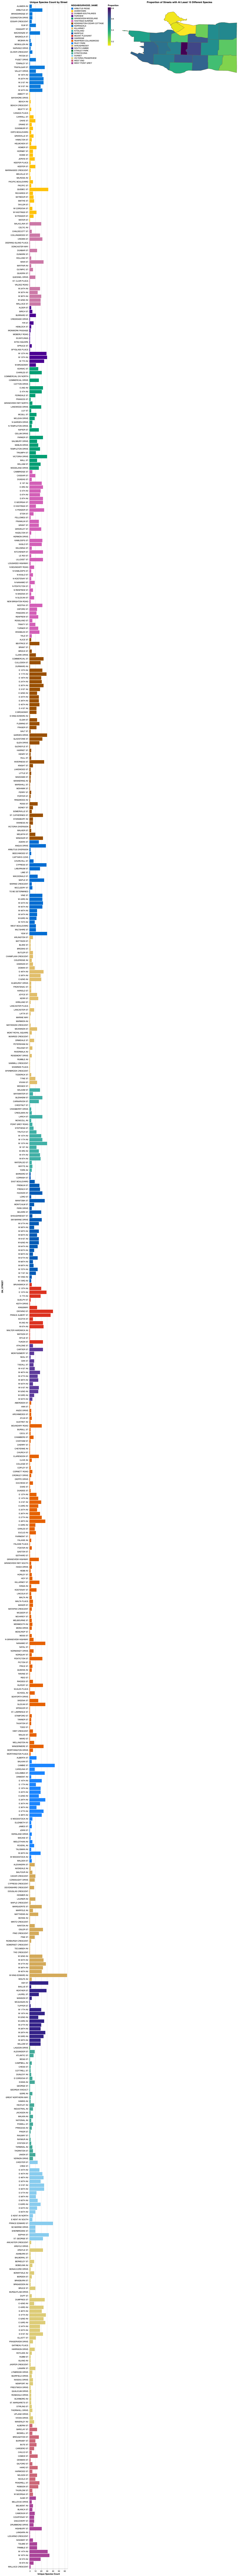

In [8]:
viz2 = bar_chart | tree_map
viz2.save(viz_folder+'plant_viz2.png')
viz2.save(viz_folder+'plant_viz2.html')
viz2